# 21-09-04-Benchmarking-ASR-first-test

## Intro
This simple jupyter notebook will demonstrate loading in the ASR results so we can view them more easily.


## Prerequistites

 - Install Jupyter notebooks with: `pip install jupyter==1.0.0`
 - Run with: `jupyter notebook`


## 0. IMPORTS

In [14]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)

# 1. DATA

In [15]:
def tidy_dataframe(df):
    # remove all superflous columns to make it smaller and easier to view
    df.drop(['vs', 'sp', 'cq', 'gg', 'aw', 'audio_hash', 'transcript_hash', 'transcript'], axis=1, inplace=True)    
    col_map = {k:k.replace('_corrected', '') for k in df.columns}
    keep_cols = [col_map[k] for k in col_map]
    df.rename(columns=col_map, inplace=True)
    
    # let's remove the filepath and keep just the filename
    df['filename'] = df.filename.str.replace('./data/simple_test/wavs/', '', regex=False)
    
    return df

df = pd.read_csv('../output/20210906_10-58-33_vs-sp-cq-gg-aw.csv')
df = tidy_dataframe(df)

In [16]:
df.head(5)

,filename,vs,sp,cq,gg,aw,transcript,vs_wer,sp_wer,cq_wer,gg_wer,aw_wer
0,109865_bear_ch0_16k.wav,bear,they are,beare,bear,There,bear,0.0,1.0,1.0,0.0,1.0
1,109879_frog_ch0_16k.wav,frog,for ah ok NOISE,forog,frog,Frog,frog,0.0,1.0,1.0,0.0,0.0
2,109886_ice-cream_ch0_16k.wav,ice cream,ice cream,i cream,ice cream,Scream,ice cream,0.0,0.0,0.5,0.0,1.0
3,109881_glass_ch0_16k.wav,glass,glass,glass,glass,Glass,glass,0.0,0.0,0.0,0.0,0.0
4,109868_camera_ch0_16k.wav,camera,camera,camera,camera,Camera,camera,0.0,0.0,0.0,0.0,0.0


# 2. WER

We can simply re-use the WER functions from SpeechLoop to show that the results are the same. We can see that some mistakes are made (especially from Sphinx where just a little cleanup will improve results).

The WER function ignores any case.


In [33]:
from speechloop.text import add_wer

def print_summary_text(df_wer):
    wer_cols = [c for c in df_wer.columns if "wer" in c]
    print(f"For a dataset of {df_wer.shape[0]} wav files")
    for w in wer_cols:
        print(f"Average value of {w} is {df_wer[w].mean():.4f}")


In [34]:
wer_cols = ['vs','sp','cq','gg','aw']
df_wer = add_wer(df, wer_cols)
assert df.equals(df_wer)

print_summary_text(df)

For a dataset of 78 wav files
Average value of vs_wer is 0.2308
Average value of sp_wer is 0.4744
Average value of cq_wer is 0.5385
Average value of gg_wer is 0.1026
Average value of aw_wer is 0.2179
Average value of comb_wer is 1.6410


In [35]:
# with pandas we can do some slightly nicer groupbys - maybe we want to know the phrases where most ASRs got it wrong

df['comb_wer'] = df.vs_wer+df.sp_wer+df.cq_wer+df.gg_wer+df.aw_wer
df.sort_values('comb_wer', ascending=False).head()

,filename,vs,sp,cq,gg,aw,transcript,vs_wer,sp_wer,cq_wer,gg_wer,aw_wer,comb_wer
23,109932_xebec_ch0_16k.wav,z back,citibank,zeback,the back,Z back,xebec,1.0,1.0,1.0,1.0,1.0,5.0
35,109905_oars_ch0_16k.wav,worse,lawyers,or,ORS,Wars,oars,1.0,1.0,1.0,1.0,1.0,5.0
43,109933_xiphias_ch0_16k.wav,z fierce,fifty s,sif hes,xiphias,Ziff Ius,xiphias,1.0,1.0,1.0,0.0,1.0,4.0
56,109882_glove_ch0_16k.wav,love,i love,love,glove,Love,glove,1.0,1.0,1.0,0.0,1.0,4.0
55,109910_pig_ch0_16k.wav,peak,panic,pick,Pig,Take,pig,1.0,1.0,1.0,0.0,1.0,4.0


# 3. CLEAN
For now it looks like we can quickly fix:
 - sphinx remove SPEECH, NOISE
 - google swap ? for "questionmark"
 - cq replace NaN with "" and swap "skate board" for "skateboard"
 - amazon "Nut shell" -> "Nutshell"
 
 Some of these make a minor difference in WER, some don't. Some should be fixed permanelty in SpeechLoop / CommonCorrections

In [36]:
df.sp = df.sp.str.replace('SPEECH', '')
df.sp = df.sp.str.replace('NOISE', '')

df.gg = df.gg.str.replace('?', 'question mark', regex=False)

df.cq = df.cq.str.replace('NaN', '')
df.cq = df.cq.str.replace('skate board', 'skateboard')

df.aw = df.aw.str.replace('Nut shell', 'Nutshell')

In [37]:
# now we can recalc the WER
df = add_wer(df, wer_cols)
df['comb_wer'] = df.vs_wer+df.sp_wer+df.cq_wer+df.gg_wer+df.aw_wer
print_summary_text(df)
df.sort_values('comb_wer', ascending=False).head()

For a dataset of 78 wav files
Average value of vs_wer is 0.2308
Average value of sp_wer is 0.4744
Average value of cq_wer is 0.5385
Average value of gg_wer is 0.1026
Average value of aw_wer is 0.2179
Average value of comb_wer is 1.5641


,filename,vs,sp,cq,gg,aw,transcript,vs_wer,sp_wer,cq_wer,gg_wer,aw_wer,comb_wer
23,109932_xebec_ch0_16k.wav,z back,citibank,zeback,the back,Z back,xebec,1.0,1.0,1.0,1.0,1.0,5.0
35,109905_oars_ch0_16k.wav,worse,lawyers,or,ORS,Wars,oars,1.0,1.0,1.0,1.0,1.0,5.0
43,109933_xiphias_ch0_16k.wav,z fierce,fifty s,sif hes,xiphias,Ziff Ius,xiphias,1.0,1.0,1.0,0.0,1.0,4.0
56,109882_glove_ch0_16k.wav,love,i love,love,glove,Love,glove,1.0,1.0,1.0,0.0,1.0,4.0
55,109910_pig_ch0_16k.wav,peak,panic,pick,Pig,Take,pig,1.0,1.0,1.0,0.0,1.0,4.0


In [38]:
df.describe()

,vs_wer,sp_wer,cq_wer,gg_wer,aw_wer,comb_wer
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.230769,0.474359,0.538462,0.102564,0.217949,1.564103
std,0.424052,0.502574,0.495232,0.305352,0.415525,1.375479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [39]:
# I export this so I can use the JSON in the blog table with grid.js
df.to_json("./21-09-04-bench-cleaned.json", orient='values', force_ascii=True)

In [51]:
df_summary = pd.DataFrame({
    'WER': [f"{df.vs_wer.mean():.4f}", 
            f"{df.sp_wer.mean():.4f}",
            f"{df.cq_wer.mean():.4f}",
            f"{df.gg_wer.mean():.4f}",
            f"{df.aw_wer.mean():.4f}"
           ],
    'name': ['Vosk', 'Sphinx', 'Coqui', 'GoogleASR', 'AWSTranscribe'],
    'type': ['Offline - Docker', 'Offline - Docker','Offline - Docker', 'Cloud - API', 'Cloud - API']

})

df_summary = df_summary.astype({'WER':float})

In [52]:
df_summary

,WER,name,type
0,0.2308,Vosk,Offline - Docker
1,0.4744,Sphinx,Offline - Docker
2,0.5385,Coqui,Offline - Docker
3,0.1026,GoogleASR,Cloud - API
4,0.2179,AWSTranscribe,Cloud - API


In [53]:
df_summary_sort = df_summary.sort_values('WER')


In [54]:
df_summary_sort

,WER,name,type
3,0.1026,GoogleASR,Cloud - API
4,0.2179,AWSTranscribe,Cloud - API
0,0.2308,Vosk,Offline - Docker
1,0.4744,Sphinx,Offline - Docker
2,0.5385,Coqui,Offline - Docker


[Text(0, 0.5, ''), Text(0.5, 0, 'WER')]

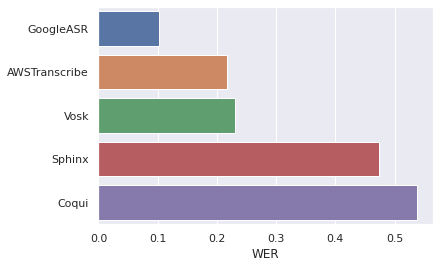

In [62]:
sns.set_color_codes("pastel")
ax = sns.barplot(x="WER", y="name", data=df_summary_sort)
ax.set(ylabel="", xlabel="WER")